In [1]:
import numpy as np
import pandas as pd
import time
from functools import partial

from scipy.stats import randint, uniform
from sim_lib import simulation

pd.options.mode.chained_assignment = None


In [2]:
def eps_greedy(history: pd.DataFrame, eps: float):
    if uniform.rvs() < eps:
        n = history.shape[0]
        return history.index[randint.rvs(0, n)]

    ctr = history['clicks'] / (history['impressions'] + 10)
    n = np.argmax(ctr)
    return history.index[n]

policy = partial(eps_greedy, eps=0.06)

seed = 18475
np.random.seed(seed=seed)

In [3]:
# seed for homework


start = time.time()
output = simulation(policy, n=200000, seed=seed)
end = time.time()
end - start

1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
40001 impressions have been simulated
50001 impressions have been simulated
60001 impressions have been simulated
70001 impressions have been simulated
80001 impressions have been simulated
90001 impressions have been simulated
100001 impressions have been simulated
110001 impressions have been simulated
120001 impressions have been simulated
130001 impressions have been simulated
140001 impressions have been simulated
150001 impressions have been simulated
160001 impressions have been simulated
170001 impressions have been simulated
180001 impressions have been simulated
190001 impressions have been simulated


270.1353814601898

In [4]:
# baseline regret
output['regret'], output['regret']/output['rounds'],  output['total_banners']

(1540.7609683932544, 0.007703804841966272, 184)

In [5]:
output['history']

,impressions,clicks,lifetime,p
153,18970.0,4199.0,18003.025431,0.220134
162,228.0,26.0,1537.166719,0.113780
172,163.0,32.0,19648.592394,0.219968
173,170.0,18.0,12771.474990,0.122694
180,26.0,3.0,4655.819793,0.020061
182,6.0,0.0,889.624649,0.004621
183,1.0,0.0,15187.163761,0.073886


Будем решать с помощью UCB, подирая коэффициент c

In [6]:
class UCB():
    def __init__(self, c: float):
        self.num_iter = 0
        self.c = c
    def __call__(self, history: pd.DataFrame):
        self.num_iter += 1
        exploration = np.sqrt(np.log(self.num_iter) * 2 / (history['impressions'] + 1)) # +1, чтобы на 0 не делить
        exploitation = history['clicks'] /(history['impressions'] + 1)
        res = np.argmax(exploitation + self.c*exploration)
        return history.index[res]

In [9]:
def get_regrets(coefficients): # дает массив regret по массиву coef
    regrets = []
    for coef in coefficients:
        ucb = UCB(coef)
        res = simulation(ucb, n=200000, seed=seed)
        print(f"c={coef}, regret={res['regret']}")
        regrets.append(res["regret"])
    return coefficients, regrets

In [7]:
import matplotlib.pyplot as plt

In [10]:
cs = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
cs, regrets = get_regrets(cs)
print(cs, regrets)

1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
40001 impressions have been simulated
50001 impressions have been simulated
60001 impressions have been simulated
70001 impressions have been simulated
80001 impressions have been simulated
90001 impressions have been simulated
100001 impressions have been simulated
110001 impressions have been simulated
120001 impressions have been simulated
130001 impressions have been simulated
140001 impressions have been simulated
150001 impressions have been simulated
160001 impressions have been simulated
170001 impressions have been simulated
180001 impressions have been simulated
190001 impressions have been simulated
c=0.001, regret=6465.622939455535
1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
40001 impressions have been simulated
50001 impressi

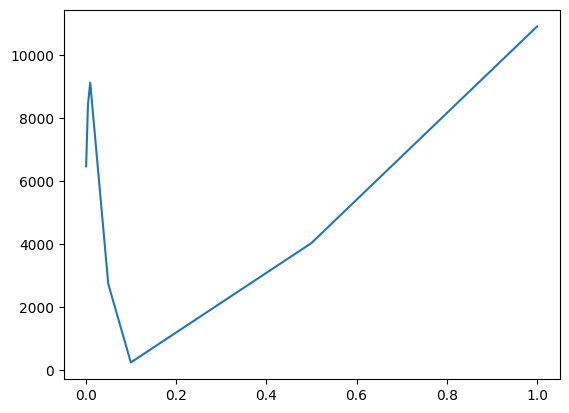

In [11]:
plt.plot(cs, regrets)
plt.show()

Становится понятно, что надо искать в районе (0.05, 0.1)

In [14]:
cs = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
cs, regrets = get_regrets(cs)

1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
40001 impressions have been simulated
50001 impressions have been simulated
60001 impressions have been simulated
70001 impressions have been simulated
80001 impressions have been simulated
90001 impressions have been simulated
100001 impressions have been simulated
110001 impressions have been simulated
120001 impressions have been simulated
130001 impressions have been simulated
140001 impressions have been simulated
150001 impressions have been simulated
160001 impressions have been simulated
170001 impressions have been simulated
180001 impressions have been simulated
190001 impressions have been simulated
c=0.05, regret=2745.7296634937716
1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
40001 impressions have been simulated
50001 impressi

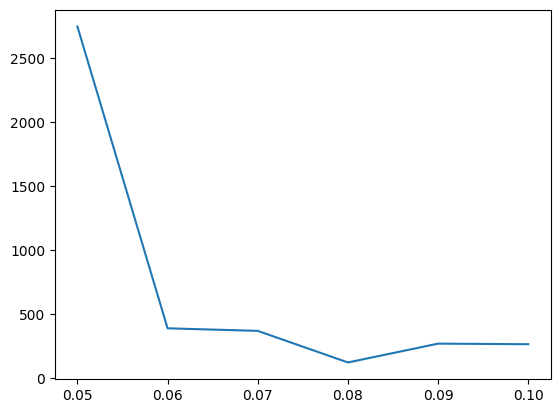

In [15]:
plt.plot(cs, regrets)
plt.show()

При 0.08 уже ~119 примерно, что уже лучше 270. Но можно поискать получше в районе (0.06 - 0.09). В 0.06, 0.07, 0.08, 0.09 теперь добавим руками значения, ибо считается долго:)

In [16]:
cs = [0.065, 0.075, 0.085]
cs, regrets = get_regrets(cs)

1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
40001 impressions have been simulated
50001 impressions have been simulated
60001 impressions have been simulated
70001 impressions have been simulated
80001 impressions have been simulated
90001 impressions have been simulated
100001 impressions have been simulated
110001 impressions have been simulated
120001 impressions have been simulated
130001 impressions have been simulated
140001 impressions have been simulated
150001 impressions have been simulated
160001 impressions have been simulated
170001 impressions have been simulated
180001 impressions have been simulated
190001 impressions have been simulated
c=0.065, regret=156.9065694922331
1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
40001 impressions have been simulated
50001 impressi

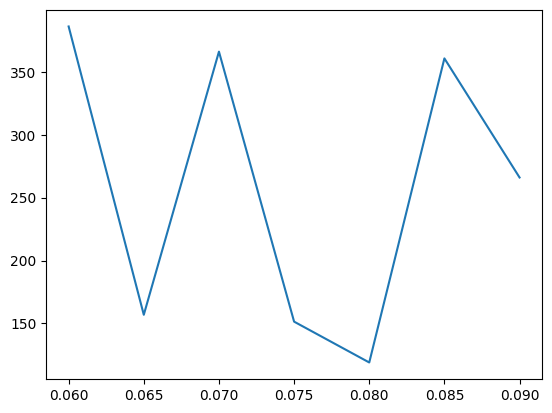

In [17]:
new_cs = [0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09]
new_regrets = [386, regrets[0], 366, regrets[1], 119, regrets[2], 266]
plt.plot(new_cs, new_regrets)
plt.show()

Поищем в районе 0.076-0.082

In [19]:
cs = [0.076, 0.077, 0.078, 0.079, 0.081]
cs, regrets = get_regrets(cs)

1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
40001 impressions have been simulated
50001 impressions have been simulated
60001 impressions have been simulated
70001 impressions have been simulated
80001 impressions have been simulated
90001 impressions have been simulated
100001 impressions have been simulated
110001 impressions have been simulated
120001 impressions have been simulated
130001 impressions have been simulated
140001 impressions have been simulated
150001 impressions have been simulated
160001 impressions have been simulated
170001 impressions have been simulated
180001 impressions have been simulated
190001 impressions have been simulated
c=0.076, regret=390.3507658249441
1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
40001 impressions have been simulated
50001 impressi

[390.3507658249441, 2099.7669772748404, 1049.0974623902412, 112.70306298881044, 119, 225.71672450120164]


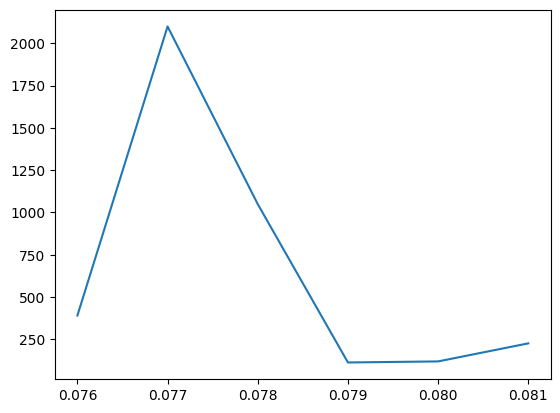

In [25]:
new_cs = [0.076, 0.077, 0.078, 0.079, 0.080, 0.081]
new_regrets = regrets[:-1] + [119] + [regrets[-1]]
print(new_regrets)
plt.plot(new_cs, new_regrets)
plt.show()

In [27]:
cs = [0.0792, 0.0794, 0.0796, 0.0798]
cs, regrets = get_regrets(cs)

1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
40001 impressions have been simulated
50001 impressions have been simulated
60001 impressions have been simulated
70001 impressions have been simulated
80001 impressions have been simulated
90001 impressions have been simulated
100001 impressions have been simulated
110001 impressions have been simulated
120001 impressions have been simulated
130001 impressions have been simulated
140001 impressions have been simulated
150001 impressions have been simulated
160001 impressions have been simulated
170001 impressions have been simulated
180001 impressions have been simulated
190001 impressions have been simulated
c=0.0792, regret=343.55216489926767
1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
40001 impressions have been simulated
50001 impres

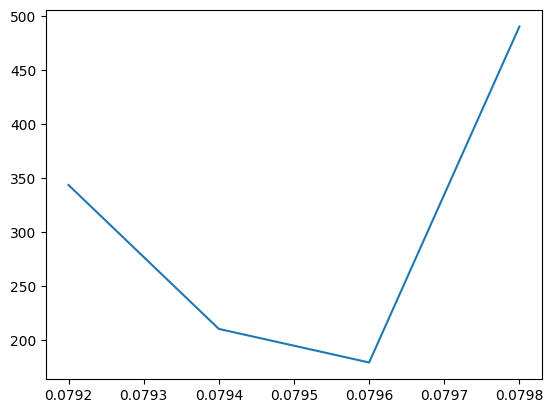

In [28]:
plt.plot(cs, regrets)
plt.show()

Вообще видно, что если посчитать на более мелкой сетке, то у графика будут некоторые неожиданные росты и падения, поэтому очень вероятно, что где-то рядом будет коэффициент с regret получше. Считать все это тоже непросто, потому остановимся н том, что нашли:) -- 0.08 с regret=119.60